# Assessment 3: Computation of slopes in a DEM
## Methods implemented: 2FD and Maximum Max

StudentID: 1033936 
Email: darrenchrist@student.unimelb.edu.au

## Introduction:
A digital elevation model (DEM) is a 3D CG representation of a terrain's surface.
Slope represents the rate of change of elevation for each digital elevation model (DEM) cell.
In this assessment, two methods are used for computing the slopes, namely Second-order finite 
difference 2FD (Fleming and Hoffer \cite{Tang2011EstimatingSF} and Maximum Max (Travis et al.) \cite{Tang2011EstimatingSF}.

In this project, an external module of rasters.py is used to store all the methods implemented.
Please refer to rasters.py for in-depth method execution.

The project downscales the raster 2x and 4x times to reduce computation time.

### Assumptions/ Declarations:
1. For this project the raster contains only 1 band. 
2. The dem conversion is done from EPSG:4326 to EPSG:3110 which is vic region, with units in meters
3. The rasters are sampled bilinearily.
4. Since the base-input file operated in this program remains constant, it is declared as a constant.
5. In max max method, we skip nodata values in calculation do avoid deviation of the result. 
6. It is given in task to have coaser 

### Imports:
1. rasterio - for raster handling, masking and plotting of data and histogram
2. numpy - for scientific( image) data handling/processing
3. rasters - python file containing supporting functions for this project
4. matplotlib- for plotting custom histograms and DEM images
5. pyproj - Used for conversion of EPSG of raster and finding respective units
5. cv2 - An OpenCv library for padding image/raster data.


### Notes:
1. Histogram and elevation model image are placed side under a single raster name and a method.
   This gives higher clarity on the reference of which raster data is plotted.
2. The result are listed one below other adjacently for easier comparison 
3. Bin size of 50 was selected to show the values with lower frequency but of high importance
   such as the max value in the current DEM. It also improves accuracy
4. The cell sizes are rounded off to 10 decimal places for display purpose only,
   of calculation, the orginal cell size is used.
5. Since this file is a report similar to a paper for comparing outputs and data representation, it lacks
    exact code implementations. They are included in rasters.py

In [1]:
from rasterio import plot,mask,rasterio
import numpy as np
import rasters
import matplotlib.pyplot as matplot
from affine import Affine
import pyproj 
from rasterio.plot import show_hist
import cv2


RASTERNAME='CLIP.tif'
RASTER_REPROJECTED='Reprojected_'+RASTERNAME
SCALED_RASTER_1_2='Scaled_1_2'+RASTER_REPROJECTED
SCALED_RASTER_1_4='Scaled_1_4'+RASTER_REPROJECTED
DOWN_SCALE_1_2= 1/2
DOWN_SCALE_1_4= 1/4
FINITE_2FD='Second-order finite difference 2FD'
MAXIMUM_MAX='Maximum Max'
EPSG_TO=3110


## Functions 
Primarily contains display functions for plotting histogram and elevations of the raster.
We use cmap 'viridis' since it has 3 range of contrasting colors to capture the details


In [2]:
"""
function calls the summary dem, which results in dictionary and then uses prettytable module 
which is called within display_summary in rasters.py to get the appropriate format table for 
this notebook.
"""

def generate_data_reprtn(file_name):
    raster_info=rasters.summary_dem(file_name)
    return rasters.display_summary(raster_info)
    

In [3]:

"""
function plots a raterio plot(matplot) of dem as an image and histogram showing
elevation values with respective frequency 
matplotlib inline: a magic commnand for Jupyter which works like OS command to for outputs 
to be plotted commands is displayed inline and stored in the notebook

"""

%matplotlib inline
def generate_visual_reprtn(file_name):
    with rasterio.open(file_name) as dem:
        fig, (axplot,axhist) = matplot.subplots(1,2, figsize=(18,7))
        axplot.set_ylabel('Latitude/ y UTM coordinate (degrees/meters)')
        axplot.set_xlabel('Longitude/ x UTM coordinate (degrees/meters)')
        axplot.set_title('Plotting of elevation data from '+ file_name,fontweight='bold')
        plot.show(dem, ax=axplot)
        
        show_hist(dem, bins=50, histtype='stepfilled',
              lw=0.0, stacked=False, alpha=0.3, ax=axhist,
              title='Data from '+ file_name)
        axhist.set_xlabel('Elevation Values')
        matplot.show()


In [4]:
"""
function which plots the slope and histogram using the data and diplays the
method name.
Please note that since the x and y axis no longer contain the coordinate data, 
the axis labels are no longer displayed

"""

def generate_slope_comparison(out_data,method_name):
    fig, ( ax_mag, ax_ang) = matplot.subplots(1, 2, figsize=(18, 7))
    ax_mag.imshow(out_data)
    ax_mag.set_title('Gradient magnitude for the slope data: '+ method_name,fontweight='bold')
    
    show_hist(out_data, bins=50, histtype='stepfilled',
                  lw=0.0, stacked=False, alpha=0.3, ax=ax_ang,
                  title='Data from Slope method: '+ method_name)
    ax_ang.set_xlabel('Slope Values')
    matplot.show()

### Program Flow:
#### Task 1:
The data from CLIP.tif is shown below in a tabular format. 
EPSG: 4326 has degrees as the units, showing the longitude and latitude,
The x and y values are the latitudes and longitude converted into UTM coodinates
based on EPSG: 3110. The height and width show the raster size.
Cell size is length of each in side (x,y) of each cell in the raster. 
The nodata is flag or a certain value which is used to highlight 
that no elevation data is present at a particular location. Min and max value are the 
min and max of the elevation values(band) for this DEM.

In [5]:
raster_table=generate_data_reprtn(RASTERNAME)
raster_table

$Parameter$,$Value$
Filename,CLIP.tif
Coordinate System,4326 [EPSG]
"Minimum x, Minimum longitude","2539847.5829088255 metre , 145.45486111162396 degree"
"Maximum x, Maximum longitude","2627857.0704815458 metre , 146.44625000052883 degree"
"Minimum y, Minimum latitude","4390250.007648419 metre , -37.97875000025906 degree"
"Maximum y, Maximum latitude","4451265.383560181 metre , -37.43680555580587 degree"
"Width, Height, Cell Size (Resolution)","3569 px , 1951 px , ('0.0002777778', '0.0002777778') metre"
Nodata,-3.4028234663852886e+38
Min value : Max value,70.18749 : 1563.1005


The below band shows plotting of CLIP.tif, along with its frequency of elevation data using the histogram.
Note that brighter areas have higher elevation and darker values have lower evelvation value in the band plot.
It can also be noted that value between 400-450 has the highest frequency in the DEM i.e above 250000.
The max values i.e 1563.1005 has the least frequncy in the entire histogram.

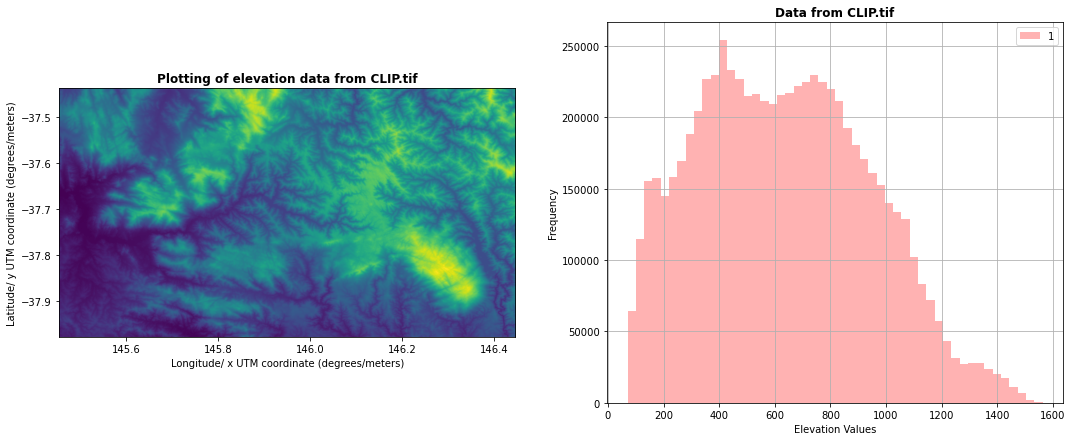

In [6]:
generate_visual_reprtn(RASTERNAME)

For finding the coordinates along with the indices of highest value, the band is sorted in descending order. 
Affine translations (50%,50%) to the tranform matrices along with right multiplication to the band coordinates is used to identify the coordinates.
Note that the grey cmap is used to highlight the coordinate. The coordinate annotate is rounded off to 5 decimal places for visual constraints. The marksize is also increased for better display purpose.

Highest value is present at: (146.29444444497085, -37.83138888914557)


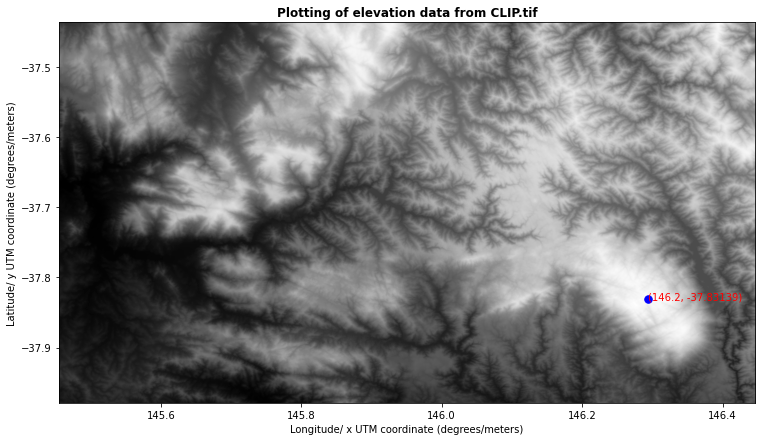

In [7]:
highest_value_coord= rasters.get_highest_value_coord(RASTERNAME)
with rasterio.open(RASTERNAME) as dem:
    fig, axrgb = matplot.subplots(1,1, figsize=(18,7))
    axrgb.annotate('(%3.5s, %3.5f)' % highest_value_coord, xy=highest_value_coord, textcoords='data',color='red')
    matplot.plot(highest_value_coord[0], highest_value_coord[1], 'b.',markersize=15)
    axrgb.set_ylabel('Latitude/ y UTM coordinate (degrees/meters)')
    axrgb.set_xlabel('Longitude/ x UTM coordinate (degrees/meters)')
    axrgb.set_title('Plotting of elevation data from '+ RASTERNAME,fontweight='bold')
    plot.show(dem,cmap='Greys_r', ax=axrgb)
print('Highest value is present at: '+ str(highest_value_coord))

#### Task 2:
Firstly, the raster is converted from EPSG: 4326 to 3110 and changes in the values is displayed in tabular format.
After reprojection the no-value data appears as min value because of projection from 4326 to 3110 since there are some 'blank' areas in the newly projected raster. x/y and longitude/latitude are equal since both are represented in meters and the DEM is in new projection. Please note the cell-size is 26.08~ meters

In [8]:
rasters.raster_reproject(RASTERNAME,RASTER_REPROJECTED,EPSG_TO)
generate_data_reprtn(RASTER_REPROJECTED)

$Parameter$,$Value$
Filename,Reprojected_CLIP.tif
Coordinate System,3110 [EPSG]
"Minimum x, Minimum longitude","2539847.5829088255 metre , 2539847.5829088255 metre"
"Maximum x, Maximum longitude","2627864.3056063056 metre , 2627864.3056063056 metre"
"Minimum y, Minimum latitude","4390248.455762491 metre , 4390248.455762491 metre"
"Maximum y, Maximum latitude","4451265.383560181 metre , 4451265.383560181 metre"
"Width, Height, Cell Size (Resolution)","3374 px , 2339 px , ('26.0867583573', '26.0867583573') metre"
Nodata,-3.4028234663852886e+38
Min value : Max value,-3.4028235e+38 : 1562.7607


The tilt in the project can be visualised in band plotting along with 'blank' spaces. It's highlighted at the edges where there is no data.
The histogram  has more values with higher frequencies compared to the former epsg:4326. Due to reprojection, the elevation values are resampled with Bilinear method.

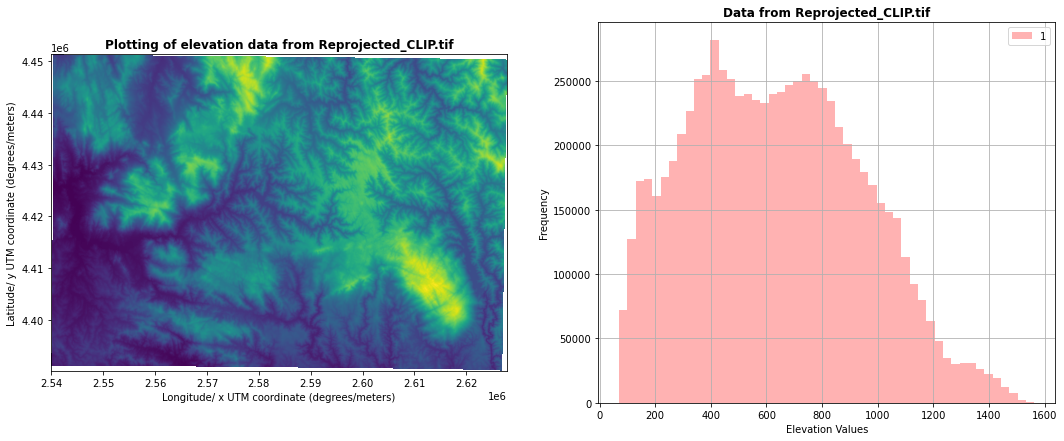

In [9]:
generate_visual_reprtn(RASTER_REPROJECTED)

The raster is down sampled 2x times as per the task. This improves performance by reducing the computational time. It can also be noted that cell size has also doubled relatively. The height and width have also been reduced by the same ratio.

In [10]:
rasters.raster_resample(RASTER_REPROJECTED,SCALED_RASTER_1_2,EPSG_TO,DOWN_SCALE_1_2)
generate_data_reprtn(SCALED_RASTER_1_2)

$Parameter$,$Value$
Filename,Scaled_1_2Reprojected_CLIP.tif
Coordinate System,3110 [EPSG]
"Minimum x, Minimum longitude","2539847.5829088255 metre , 2539847.5829088255 metre"
"Maximum x, Maximum longitude","2627864.3056063056 metre , 2627864.3056063056 metre"
"Minimum y, Minimum latitude","4390248.455762491 metre , 4390248.455762491 metre"
"Maximum y, Maximum latitude","4451265.383560181 metre , 4451265.383560181 metre"
"Width, Height, Cell Size (Resolution)","1687 px , 1169 px , ('52.1735167146', '52.1958321623') metre"
Nodata,-3.4028234663852886e+38
Min value : Max value,-3.4028235e+38 : 1561.2935


For the given resampled (down sampled 1/2) raster the histogram shows the reduction in frequency. The elevation values beteen 400 and 450 has highest frequency even in this case.  

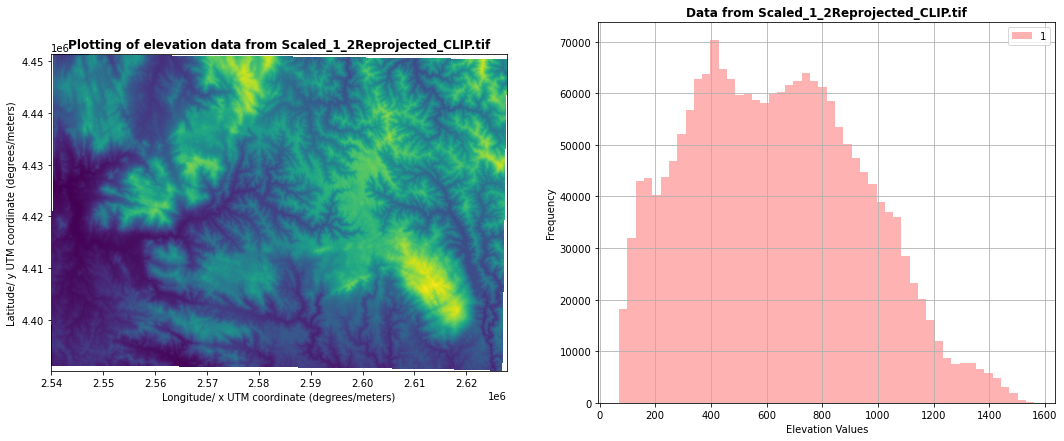

In [11]:
generate_visual_reprtn(SCALED_RASTER_1_2)

The given below resampling (down sampled 1/4) is conducted for the reprojected raster. It is noted that cell size is increased by 4 times of the original reprojected raster. Similarly the width and height reduced with the same ratio. 

In [12]:
rasters.raster_resample(RASTER_REPROJECTED,SCALED_RASTER_1_4,EPSG_TO,DOWN_SCALE_1_4)
generate_data_reprtn(SCALED_RASTER_1_4)

$Parameter$,$Value$
Filename,Scaled_1_4Reprojected_CLIP.tif
Coordinate System,3110 [EPSG]
"Minimum x, Minimum longitude","2539847.5829088255 metre , 2539847.5829088255 metre"
"Maximum x, Maximum longitude","2627864.3056063056 metre , 2627864.3056063056 metre"
"Minimum y, Minimum latitude","4390248.455762491 metre , 4390248.455762491 metre"
"Maximum y, Maximum latitude","4451265.383560181 metre , 4451265.383560181 metre"
"Width, Height, Cell Size (Resolution)","843 px , 584 px , ('104.4089237218', '104.4810407495') metre"
Nodata,-3.4028234663852886e+38
Min value : Max value,-3.4028235e+38 : 1559.2361


In the given below histogram represantation it is noted that the frequencies are for the reduced. The elevation values 400~450 are still having the highest frequency and 450 to 800 are having similarly higher frequencies compared to the rest of the data. Furthermore, the frequencies decrease for elevation values greater than 800. 

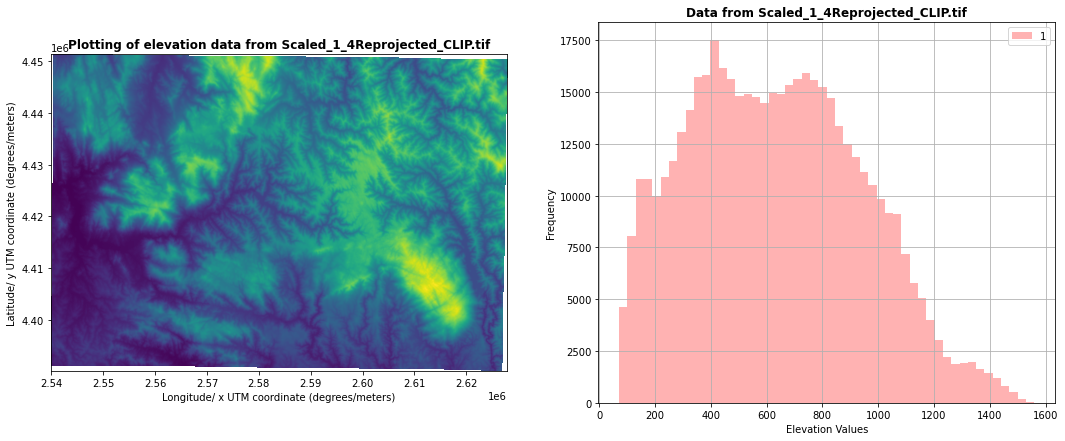

In [13]:
generate_visual_reprtn(SCALED_RASTER_1_4)

### The methods used for calculations of slope:
The methods are implemented for the rasters resampled by 1/2 and 1/4. 

#### 2FD: 
With reference to the given paper (reference) the Second-order finite difference 2FD is implemented with the kernel fx=
[[0,0,0],[-0.5,0,0.5],[0,0,0]], fy= [[0,-0.5,0],[0,0,0],[0,0.5,0]] \cite{Kevin}. 
This method uses convolutions to determine the slopes. It is noted that 'no-data' values do not have significant effect on the calculations.

#### Maximum max: 
The method it is implemented by calculating the slopes of the edges with respect to the cell under consideration. 
This method uses moving window functions to process the rasters \cite{Kevin}. The no data values at the edges are ignored for the computations since the deviate the results by a significant amount due to 'absolute' values being considered. 

##### The given methods are implemented on raster resampled by 1/4

In [14]:
out_2FD=rasters.calc_slope_2fd(SCALED_RASTER_1_4)
out_maxmax=rasters.calc_slope_maxmax(SCALED_RASTER_1_4)

For the result, it is noted that large no.of values lie between 0 and 0.8 with some exceptions at 1.55. The frequency of slope values goes above 40000 for values between 0.075 and 0.185, for 2FD method. It can also be noted that the images are more pixelated compared to resampling of 1/2.

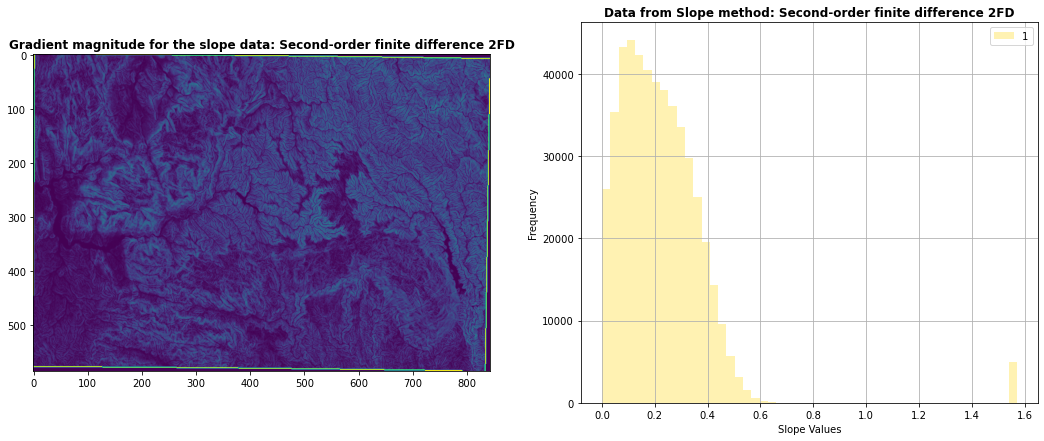

In [15]:
generate_slope_comparison(out_2FD,FINITE_2FD)

In Maximum max method gives the slope values similar to 2FD but the frequency is more uniform compared to 2FD. Here the max slpope values reach 0.8. It can also be noted that the edges in the gradient magnitude have 'black color' due to skipping of nodata values.

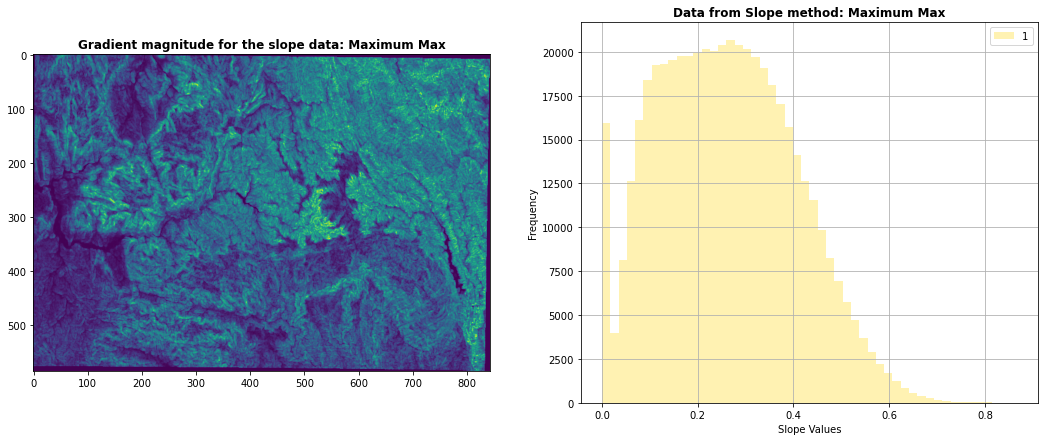

In [16]:
generate_slope_comparison(out_maxmax,MAXIMUM_MAX)

##### Repeat the above experiment for resampled raster with resampling of 1/2. 
The kernels and the implementation remains the same, but the input is different for this case.

In [17]:
out_2FD=rasters.calc_slope_2fd(SCALED_RASTER_1_2)
out_maxmax=rasters.calc_slope_maxmax(SCALED_RASTER_1_2)

The result of the histrogram shows that the frequency is higher compared to the previous 2FD implementation of resampled 1/2 raster. The distribution of the values is similar to the previous experiment, but with higher frequency of slope values.

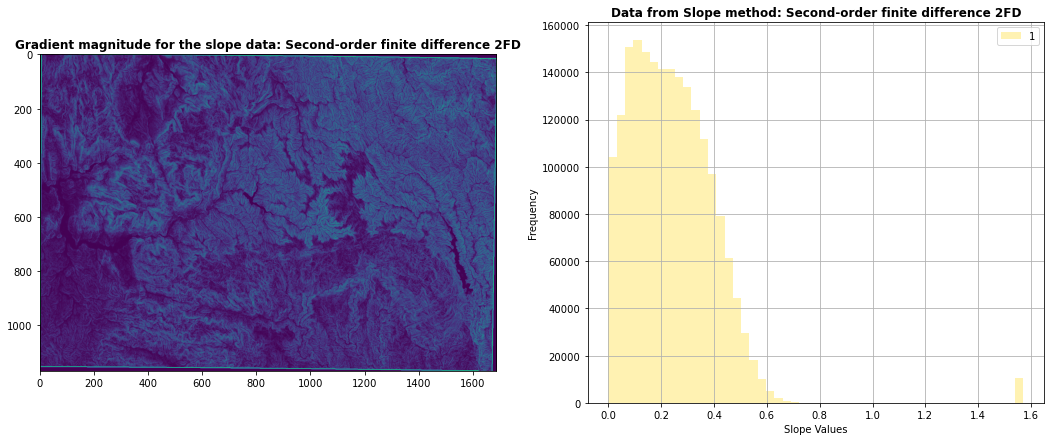

In [18]:
generate_slope_comparison(out_2FD,FINITE_2FD)

Similarily, the result for maximum max also has higher frequency compared to the previous resampling.

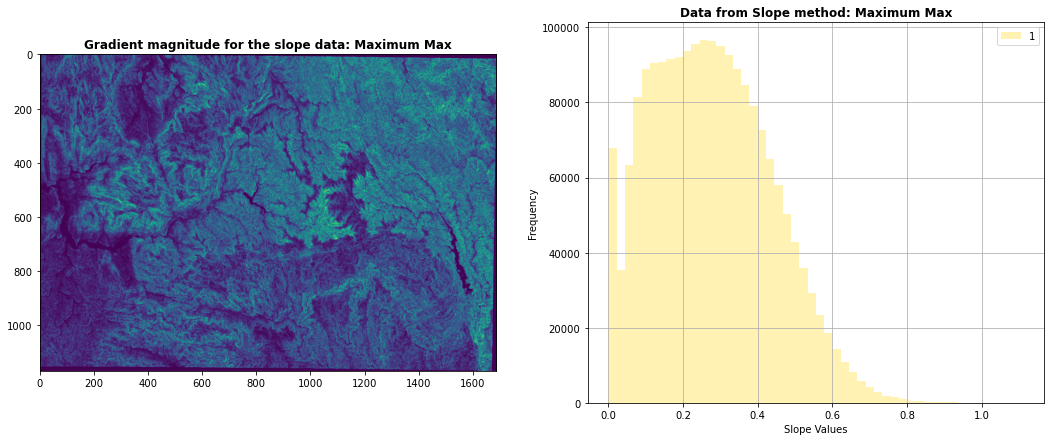

In [19]:
generate_slope_comparison(out_maxmax,MAXIMUM_MAX)

## Conclusion:
In this experiment, the raster is reporojected as well as resampled to 1/2 and 1/4. The results are compared between all the methods( 2FD and Maximum max). It can concluded that, even though the frequencies change the slope values remain uniformily distributed to give rise to a similar slope representation as seen in the plotting.